In [639]:
import numpy as np
import pandas as pd
import scipy.stats as sc_stats
import matplotlib.pyplot as plt

In [640]:
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({
  'font.size': 12,
  'grid.alpha': 0.25})

## Function declarations

### Read `ods` to `DataFrame`

In [641]:
def read_ods(filename, columns):
  key_arr = (k for k in columns.keys())
  df = pd.read_excel(filename, engine="odf", header=0,
                     usecols=columns)
  df = df.rename(columns=columns)
  return df

### Standard error of autocorrelation

In [642]:
def std_error(r_k_arr, k, n):
  r_k_arr = np.array(r_k_arr)
  r_k_arr = r_k_arr[:k-1] if len(r_k_arr) > 1 else [0]
  r_k_arr = np.array(r_k_arr)
  return np.sqrt((1 + 2*sum(r_k_arr**2))/n)


### Compute `r_k`, `t_test`, and `LBQ`

In [643]:
def get_correlogram(dataframe, up_to_lag, columns=[None, None], 
                    significance_lvl=0.05):
  df = dataframe.copy()

  Y_t = df[columns[1]].to_numpy()

  mean_Y_t = np.mean(Y_t)

  r_lag_arr = np.empty(up_to_lag)
  denom = np.sum((Y_t - mean_Y_t)**2)

  num_of_samples = len(Y_t)
  dof = num_of_samples - 1   # degree of freedom
  l_bound = sc_stats.t.ppf(significance_lvl/2, dof)
  u_bound = sc_stats.t.ppf(1-significance_lvl/2, dof)
  #print(f"[l_bound, r_bound] = [{l_bound}, {u_bound}]")

  std_error_arr = np.empty(up_to_lag)
  significance_lim_arr = np.empty([up_to_lag, 2])

  t_test_arr = np.empty(up_to_lag)

  # Ljung-Box Q statistic
  coeff = num_of_samples*(num_of_samples + 2)
  LBQ_arr = np.empty(up_to_lag)

  for lag in range(1, up_to_lag+1):
    numer = (Y_t[:-lag]  - mean_Y_t) * (Y_t[lag:] - mean_Y_t)
    numer = np.sum(numer)
    # print(f"numer = {numer}")
    # print(f"denom = {denom}")
    r_lag = numer / denom
    r_lag_arr[lag-1] = r_lag 
    std_error_arr[lag-1] = std_error(r_lag_arr[:lag], lag, num_of_samples)
    #print(f"std_error_r_{lag:<2d}: {std_error_arr[lag-1]}")
    significance_lim_arr[lag-1, 0] = l_bound*std_error_arr[lag-1]
    significance_lim_arr[lag-1, 1] = u_bound*std_error_arr[lag-1]

    t_test_arr[lag-1] = r_lag / std_error_arr[lag-1]
    # print(f"r_{lag:<2d} = {r_lag_arr[lag-1]:9.6f}")

    LBQ_arr[lag-1] = coeff*np.sum((r_lag_arr[:lag]**2)/(num_of_samples - np.arange(1, lag+1)))


  df_result = pd.DataFrame({
    "k": np.arange(1, up_to_lag+1), 
    "r_k": r_lag_arr, 
    "t_test": t_test_arr, 
    "LBQ": LBQ_arr,
    "l_bound": significance_lim_arr[:,0],
    "u_bound": significance_lim_arr[:,1]  
  })
  return df_result

### Plot of autocorrelation function

In [644]:
def plot_autocorr_func(df_acorr_analysis, title=None):
  fig, ax = plt.subplots(figsize=(7, 3))

  lag_arr = df_acorr_analysis["k"].to_numpy()
  stem_handler = ax.stem(lag_arr, df_acorr_analysis["r_k"].to_numpy())

  ax.plot(lag_arr, df_acorr_analysis["l_bound"], linestyle='--', color="gray")
  ax.plot(lag_arr, df_acorr_analysis["u_bound"], linestyle='--', color="gray")

  # [0] = markerline handler
  # [1] = stemlines handler
  # [2] = baseline handler
  stem_handler[0].set_marker(None)
  stem_handler[1].set_linewidth(4)
  stem_handler[2].set_alpha(0)

  ax.grid("on")
  ax.set_ylim([-1.1, 1.1])
  ax.set_xlabel("Lag")
  ax.set_ylabel("Autocorrelation")
  ax.set_title(f"Autocorrelation Function for {title}\n"
    + "(with 5% significance limits for the autocorrelations)")

  plt.show(fig)


In [645]:
filename = "table-3.ods"

df_asli = read_ods(filename, {"Period": "t", "Amount": "Y_t"})

num_of_quarters = 114
df = df[:num_of_quarters]   
df_test = df[num_of_quarters:]

df.head()

,t,Y_t
0,1,725
1,2,789
2,3,893
3,4,823
4,5,917


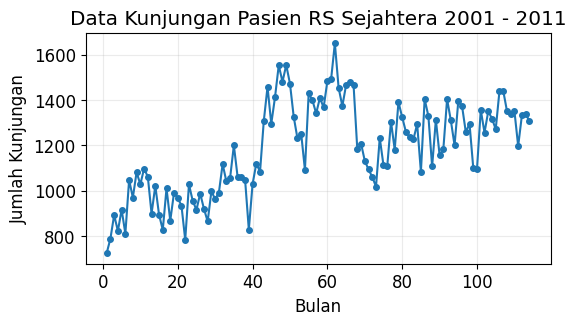

In [646]:
fig, ax = plt.subplots(figsize=(6, 3))

ax.plot(df["t"], df["Y_t"], marker='o', markersize=4)
ax.set_xlabel("Bulan")
ax.set_ylabel("Jumlah Kunjungan")
ax.set_title("Data Kunjungan Pasien RS Sejahtera 2001 - 2011")
ax.grid("on")
plt.show(fig)

In [647]:
num_of_rk = 24
df_acorr_analysis = get_correlogram(df, num_of_rk, columns=['t', "Y_t"])
df_acorr_analysis

,k,r_k,t_test,LBQ,l_bound,u_bound
0,1,0.786682,8.399467,72.424086,-0.185555,0.185555
1,2,0.733085,5.232415,135.877289,-0.277572,0.277572
2,3,0.710775,4.169674,196.064413,-0.337718,0.337718
3,4,0.568865,2.921266,234.967959,-0.385800,0.385800
4,5,0.543863,2.604691,270.853225,-0.413674,0.413674
5,6,0.500514,2.266016,301.527351,-0.437600,0.437600
6,7,0.416969,1.808089,323.014868,-0.456886,0.456886
7,8,0.370814,1.563732,340.169020,-0.469805,0.469805
8,9,0.416309,1.719098,361.996574,-0.479777,0.479777
9,10,0.364820,1.468884,378.919961,-0.492057,0.492057


In [648]:
df_acorr_analysis.to_excel("no-3-a.xlsx")

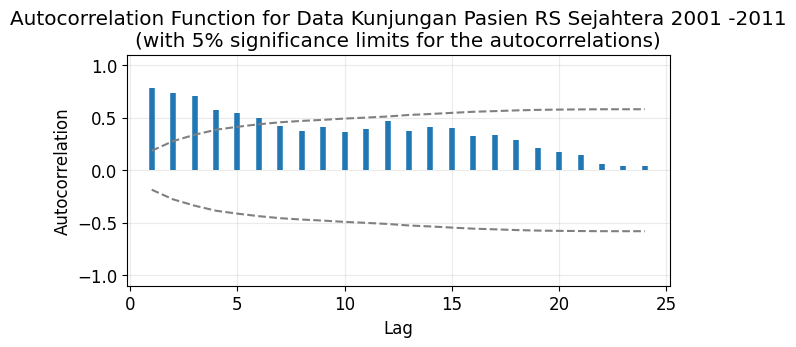

In [649]:
plot_autocorr_func(df_acorr_analysis, title="Data Kunjungan Pasien RS Sejahtera 2001 -2011")

# Winter's method 

In [650]:
df_forecast_winter = df_asli.copy()

Y_t = df_forecast_winter["Y_t"].to_numpy()

alpha = 0.6
beta = 0.027
gamma = 0.063
p = 1
s = 18

# The initial setting is only for RS Sejahtera
init_L_t = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 931.16]
init_T_t = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3.13]
init_S_t = [0.87, 0.85, 0.96, 0.88, 0.98, 0.87, 1.12, 1.04, 1.16, 1.10, 1.18, 1.14, 0.96, 1.10, 0.96, 0.89, 1.09, 0.93]

num_of_rows = len(Y_t)
L_t = np.empty(num_of_rows)
T_t = np.empty(num_of_rows)
S_t = np.empty(num_of_rows)
L_t[:18] = init_L_t
T_t[:18] = init_T_t
S_t[:18] = init_S_t

for i in range(18, len(df_forecast_winter)):
  L_t[i] = alpha*Y_t[i]/(S_t[i-s]) + (1 - alpha)*(L_t[i-1] + T_t[i-1]) 
  T_t[i] = beta*(L_t[i] - L_t[i-1]) + (1 - beta) * T_t[i-1]
  S_t[i] = gamma*Y_t[i]/L_t[i] + (1 - gamma)*S_t[i-s]


df_forecast_winter["L_t"] = L_t
df_forecast_winter["T_t"] = T_t
df_forecast_winter["S_t"] = S_t
df_forecast_winter["S_tMsPp"] = df_forecast_winter["S_t"].shift(17)

df_forecast_winter[f"hat_Y_tP{p}"] = ((df_forecast_winter["L_t"] + p*df_forecast_winter["T_t"]) \
  *df_forecast_winter["S_tMsPp"]).shift(p)


df_forecast_winter["e_t"] = df_forecast_winter["Y_t"] - df_forecast_winter[f"hat_Y_tP{p}"]

L_t = df_forecast_winter["L_t"].to_numpy()
T_t = df_forecast_winter["T_t"].to_numpy()
S_t = df_forecast_winter["S_t"].to_numpy()

L_t[-18:] = np.NaN
T_t[-18:] = np.NaN 
S_t[-18:] = np.NaN

df_forecast_winter["L_t"] = L_t
df_forecast_winter["T_t"] = T_t 
df_forecast_winter["S_t"] = S_t


# Update hat_Y_tPp (the last four row have different p ranging from 1 to 12)
hat_Y_tPp = df_forecast_winter[f"hat_Y_tP{p}"].to_numpy()
L_t = df_forecast_winter["L_t"].to_numpy()
T_t = df_forecast_winter["T_t"].to_numpy()
S_t = df_forecast_winter["S_t"].to_numpy()
for p_i in range(s):
  hat_Y_tPp[-s+p_i] = (L_t[-s-1] + (p_i+1)*T_t[-s-1])*S_t[(-s-1)-s+(p_i+1)]
  
df_forecast_winter[f"hat_Y_tP{p}"] = hat_Y_tPp


In [651]:
df_forecast_winter.head()

,t,Y_t,L_t,T_t,S_t,S_tMsPp,hat_Y_tP1,e_t
0,1,725.0,0.0,0.0,0.87,NaN,NaN,NaN
1,2,789.0,0.0,0.0,0.85,NaN,NaN,NaN
2,3,893.0,0.0,0.0,0.96,NaN,NaN,NaN
3,4,823.0,0.0,0.0,0.88,NaN,NaN,NaN
4,5,917.0,0.0,0.0,0.98,NaN,NaN,NaN


In [652]:
df_forecast_winter.to_excel("no-3-b.xlsx")

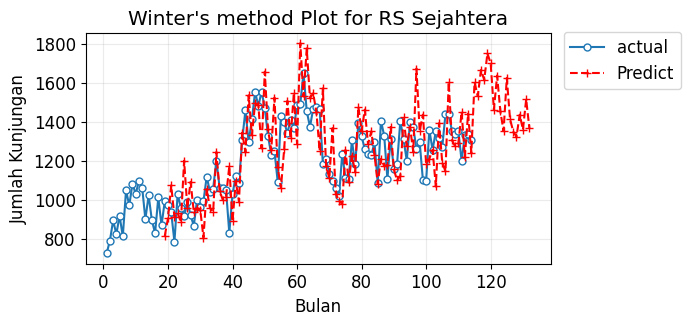

In [653]:
from turtle import color


fig, ax = plt.subplots(figsize=(6, 3))

ax.plot(df_forecast_winter["t"], df_forecast_winter["Y_t"], 
  marker='o', markersize=5, markerfacecolor='white',
  label="actual")

forecast_key = f"hat_Y_tP{p}"
ax.plot(df_forecast_winter["t"], df_forecast_winter[forecast_key], 
  marker='+', markersize=6, linestyle='--', color='red',
  label="Predict")

ax.set_xlabel("Bulan")
ax.set_ylabel("Jumlah Kunjungan")
ax.set_title("Winter's method Plot for RS Sejahtera")
ax.legend(loc="upper left", bbox_to_anchor=[1.01, 1.04])
ax.grid("on")
plt.show(fig)

In [654]:
def get_accuracy_measures(dataframe, columns=["Y_t", "hat_Y_t"]):
  Y_t = dataframe[columns[0]]
  hat_Y_t = dataframe[columns[1]]

  MAPE = (((Y_t - hat_Y_t).abs())/Y_t).mean()
  MAD = (Y_t - hat_Y_t).abs().mean()
  MSE = ((Y_t - hat_Y_t)**2).mean()
  MPE = ((Y_t - hat_Y_t)/Y_t).mean()
  
  return MAPE, MAD, MSE, MPE

In [655]:
MAPE, MAD, MSE, _  = get_accuracy_measures(df_forecast_winter, columns=["Y_t", f"hat_Y_tP{p}"])
print(f"(alpha, beta, gamma) = ({alpha}, {beta}, {gamma})")
print(f"MAD    {MAD:8.3f}")
print(f"MSE    {MSE:8.3f}")
print(f"MAPE   {MAPE*100:>9.2f}%")

(alpha, beta, gamma) = (0.6, 0.027, 0.063)
MAD     125.842
MSE    25989.915
MAPE       10.31%


In [656]:
num_of_rk = 36 

df_winter = df_forecast_winter.copy()
df_winter = df_winter.dropna().reset_index(drop=True)
df_acorr_analysis = get_correlogram(df_winter, num_of_rk, columns=['t', "e_t"])
df_acorr_analysis


,k,r_k,t_test,LBQ,l_bound,u_bound
0,1,-0.197148,-1.931650,3.849101,-0.202619,0.202619
1,2,0.063620,0.600444,4.254194,-0.210347,0.210347
2,3,-0.024358,-0.229037,4.314217,-0.211135,0.211135
3,4,-0.039876,-0.374738,4.476821,-0.211251,0.211251
4,5,-0.045846,-0.430217,4.694123,-0.211559,0.211559
5,6,-0.125586,-1.176220,6.342804,-0.211967,0.211967
6,7,0.047809,0.441458,6.584424,-0.215000,0.215000
7,8,-0.121991,-1.124149,8.175414,-0.215436,0.215436
8,9,-0.039872,-0.362683,8.347333,-0.218253,0.218253
9,10,-0.074940,-0.680728,8.961697,-0.218552,0.218552


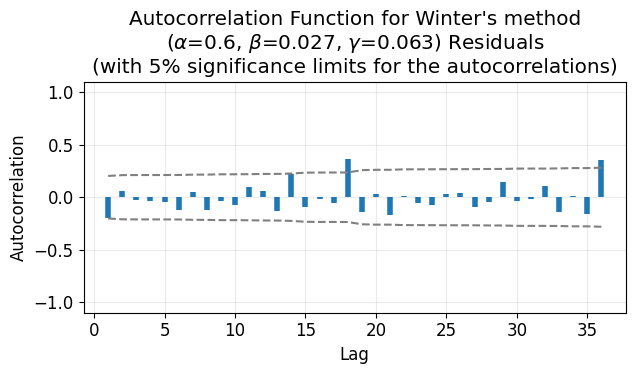

In [657]:
plot_autocorr_func(df_acorr_analysis, title="Winter's method\n"r"($\alpha$=0.6, $\beta$=0.027, $\gamma$=0.063) Residuals")